In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import itertools
from matplotlib import gridspec
from scipy.signal import find_peaks

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disabpd.option_context('display.max_columns', 300)le copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps.get_cmap('RdYlBu')

# Dados

In [2]:
#Importando os dados de um arquivo .csv
data = pd.read_csv('Dados_PenduloFisico/amortecido/amortecido.txt', header = 0, sep = '\t', encoding='latin-1')

In [3]:
tempo = np.array(data['Tempo ( s )']) - 7.8720
angulo = np.array(data['Posição angular ( graus )'])

for i,t in enumerate(tempo):
    if t >= 0:
        tempo = tempo[i:]
        angulo = angulo[i:]
        break


# Gráfico

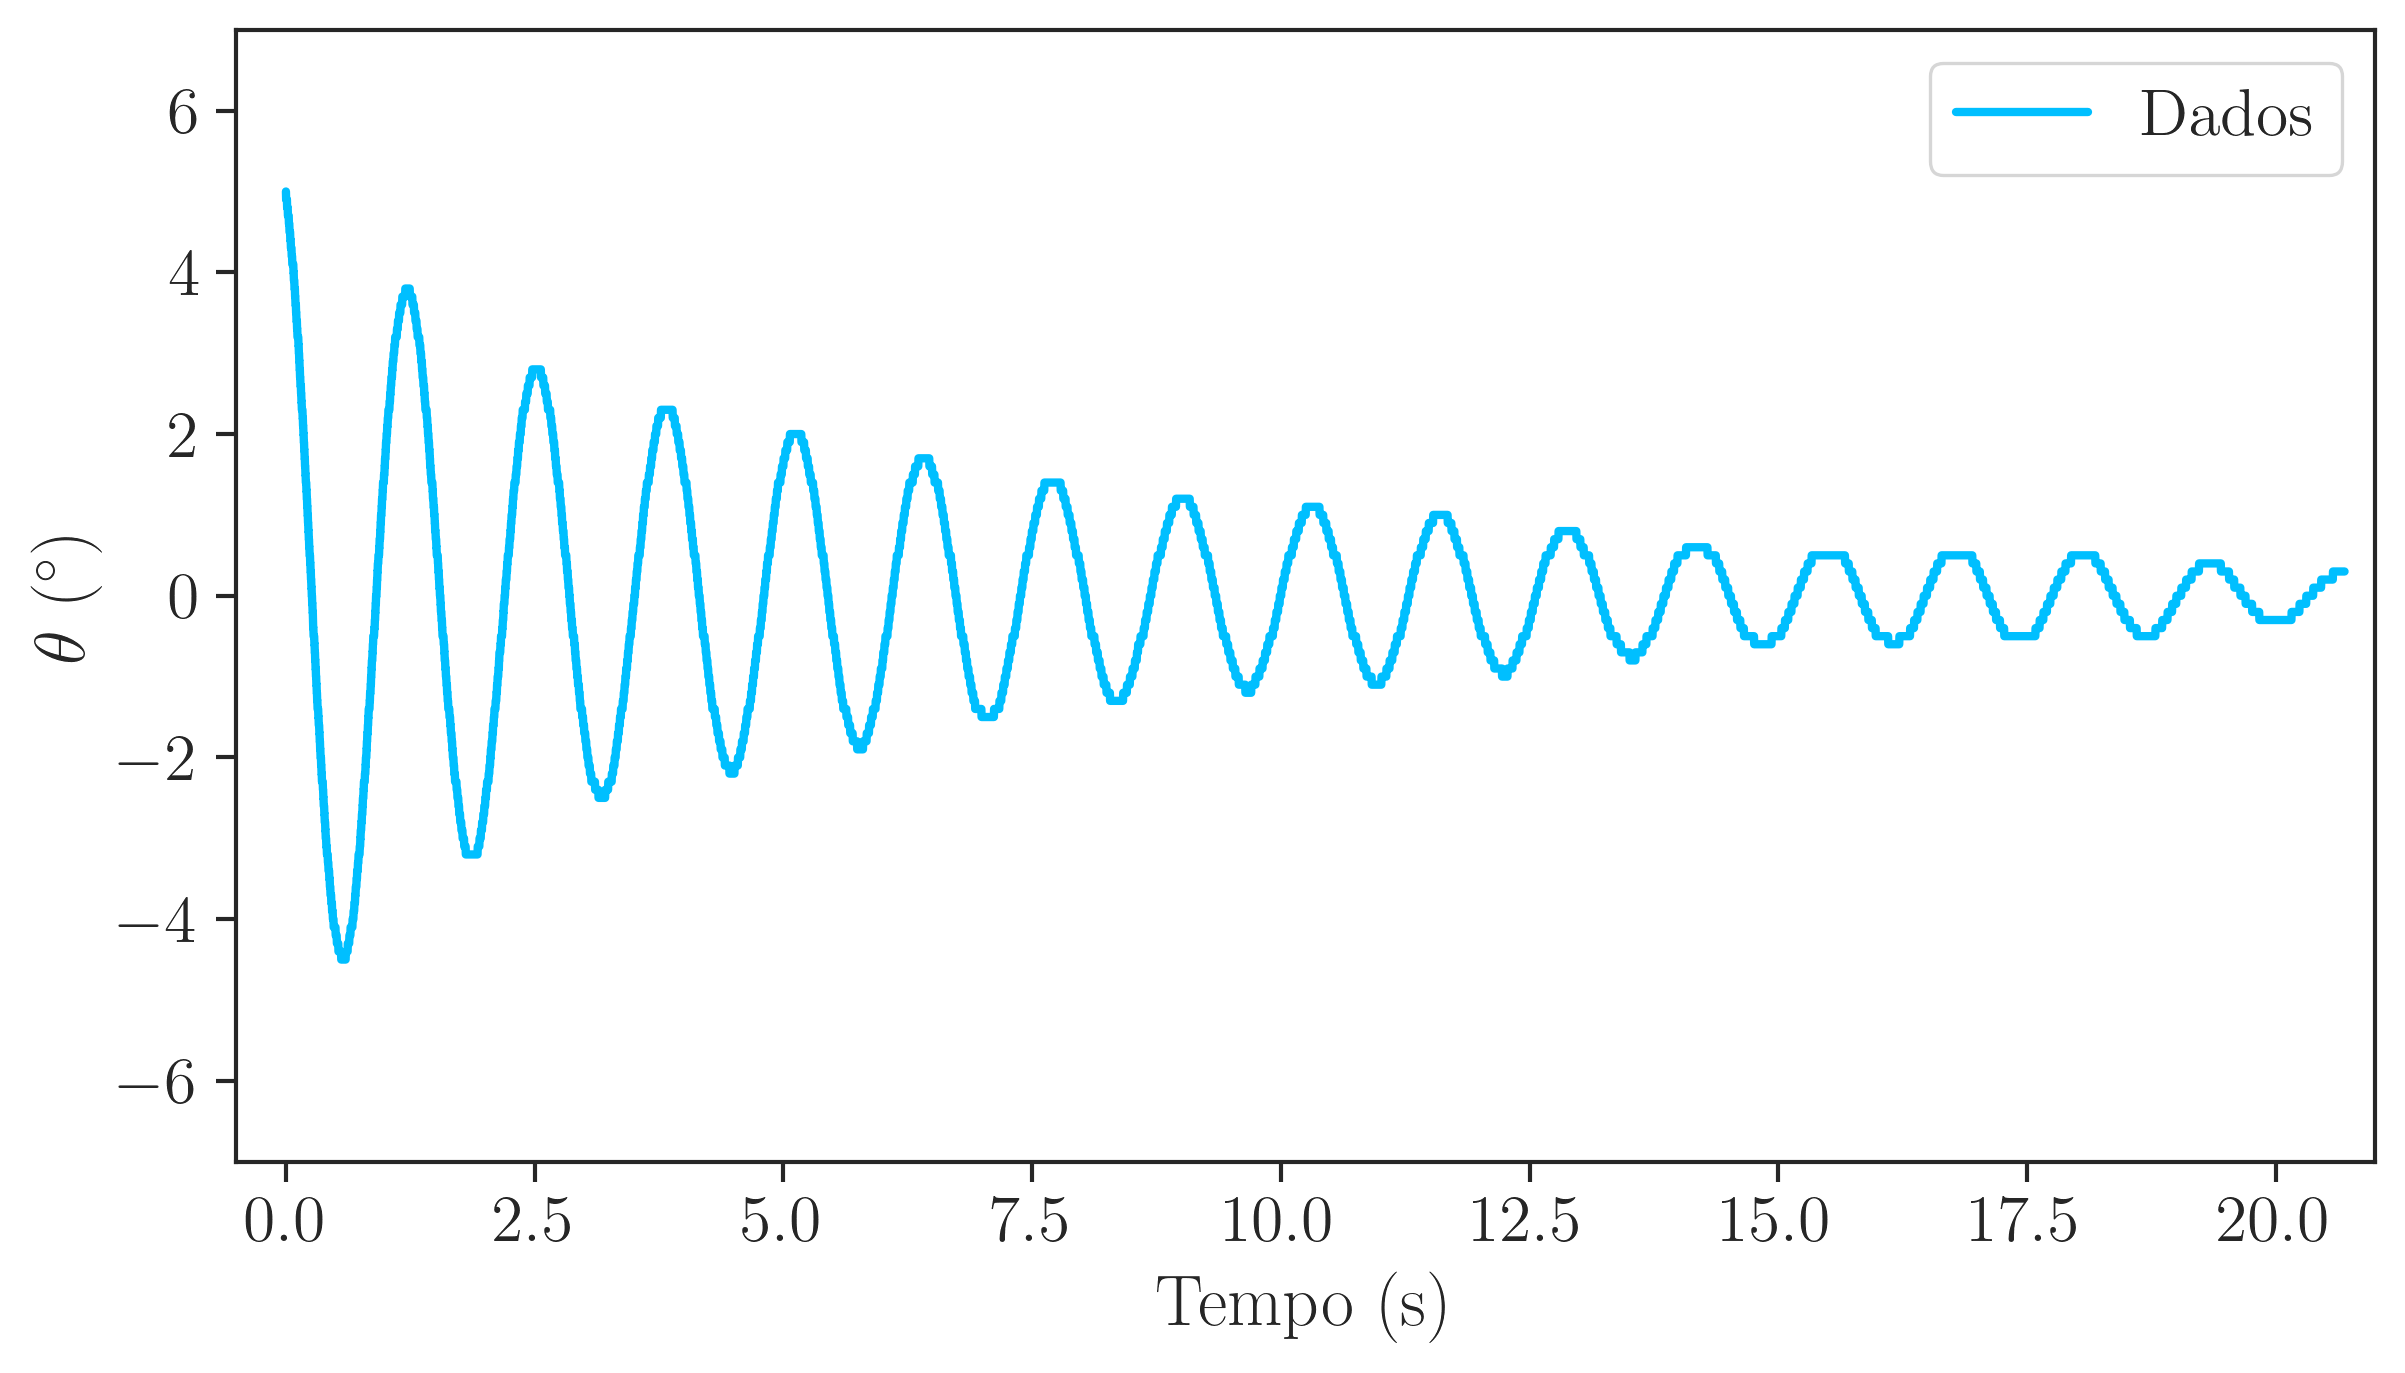

In [4]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
plt.plot(tempo, angulo, lw =2, color = 'deepskyblue', label = r'Dados')
#Visualização dos picos
#plt.scatter(tempo_5_345[peaks], angulo_5_345[peaks], color = 'red')


plt.ylabel(r'$\theta \ ({}^\circ)$')
plt.xlabel('Tempo (s)')
plt.xlim([-0.5,21])
plt.ylim([-7,7])
plt.legend()
plt.show()

# Gráfico da amplitude em função do tempo

In [5]:
peaks, _ = find_peaks(angulo, height=0)

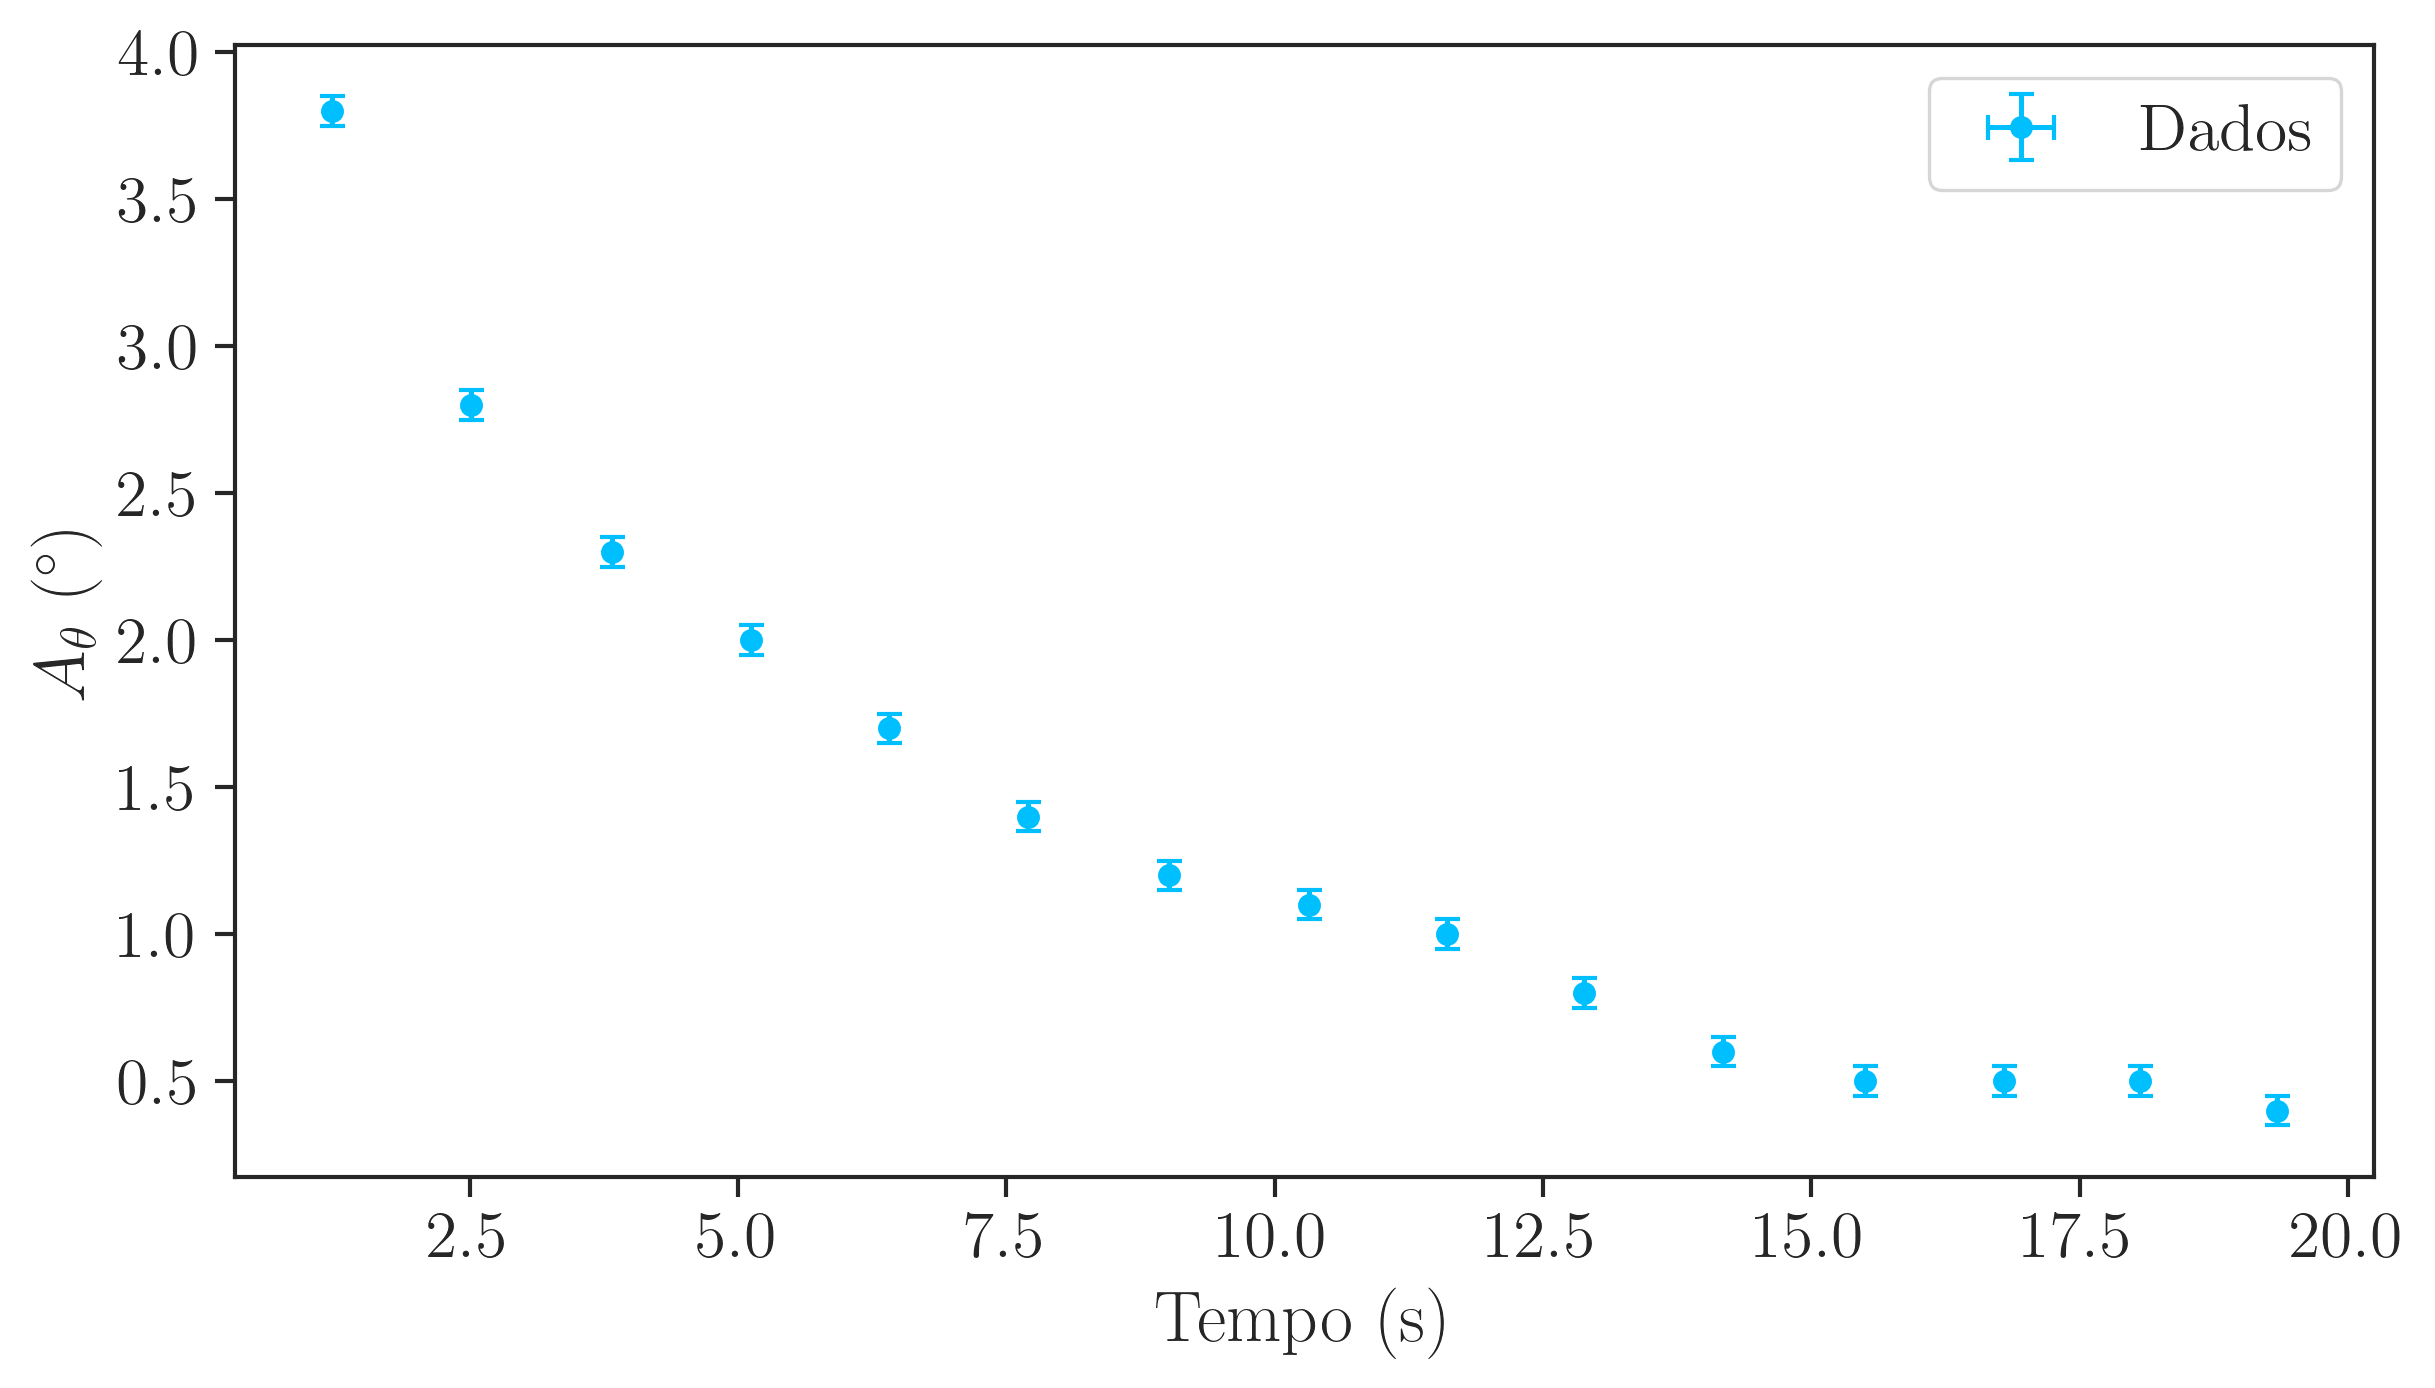

In [6]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
plt.errorbar(tempo[peaks], angulo[peaks],5e-2 ,7e-5, 'o',ms = 4.5, capsize=3, color = 'deepskyblue', label = r'Dados')
#Visualização dos picos
#plt.scatter(tempo_5_345[peaks], angulo_5_345[peaks], color = 'red')


plt.ylabel(r'$A_\theta \ ({}^\circ)$')
plt.xlabel('Tempo (s)')

plt.legend()
plt.show()

## Linearizando os dados

Da teoria, nós sabemos que a amplitude deve seguir a seguinte relação:

$$A_\theta(t) = \theta_0 e^{-\frac{b}{2I}t}$$

Tendo isto em vista, podemos aplicar o logaritmo natural dos dois lados para termos uma relação linear:

$$\ln{A_\theta(t)} = \ln{\theta_0} + \ln{e^{-\frac{b}{2I}t}}$$
$$\ln{A_\theta(t)} = \ln{\theta_0} -\frac{b}{2I}t$$

Ao calcularmos o logaritmo natural da amplitude, também devemos propagar sua incerteza:

$$\sigma_{A_\theta} = \bigg\vert\frac{d\ln{A_\theta}}{dA_\theta}\bigg\vert\sigma_{A_\theta} = \frac{\sigma_{A_\theta}}{A_\theta}$$

In [7]:
#Definindo a amplitude e sua incerteza
sigma_amp = 5e-2 #graus
amp = angulo[peaks]

#Calculando o logaritmo natural e sua incerteza
ln_amp = np.log(amp)
sigma_ln_amp = sigma_amp/amp
sigma_ln_amp = [float('{:g}'.format(float('{:.1g}'.format(sigma)))) for sigma in sigma_ln_amp]
print('ln_amp:', ln_amp)
print()
print('sigma_ln_amp:', sigma_ln_amp)

ln_amp: [ 1.33500107  1.02961942  0.83290912  0.69314718  0.53062825  0.33647224
  0.18232156  0.09531018  0.         -0.22314355 -0.51082562 -0.69314718
 -0.69314718 -0.69314718 -0.91629073]

sigma_ln_amp: [0.01, 0.02, 0.02, 0.03, 0.03, 0.04, 0.04, 0.05, 0.05, 0.06, 0.08, 0.1, 0.1, 0.1, 0.1]


## Gráfico dos dados linearizados

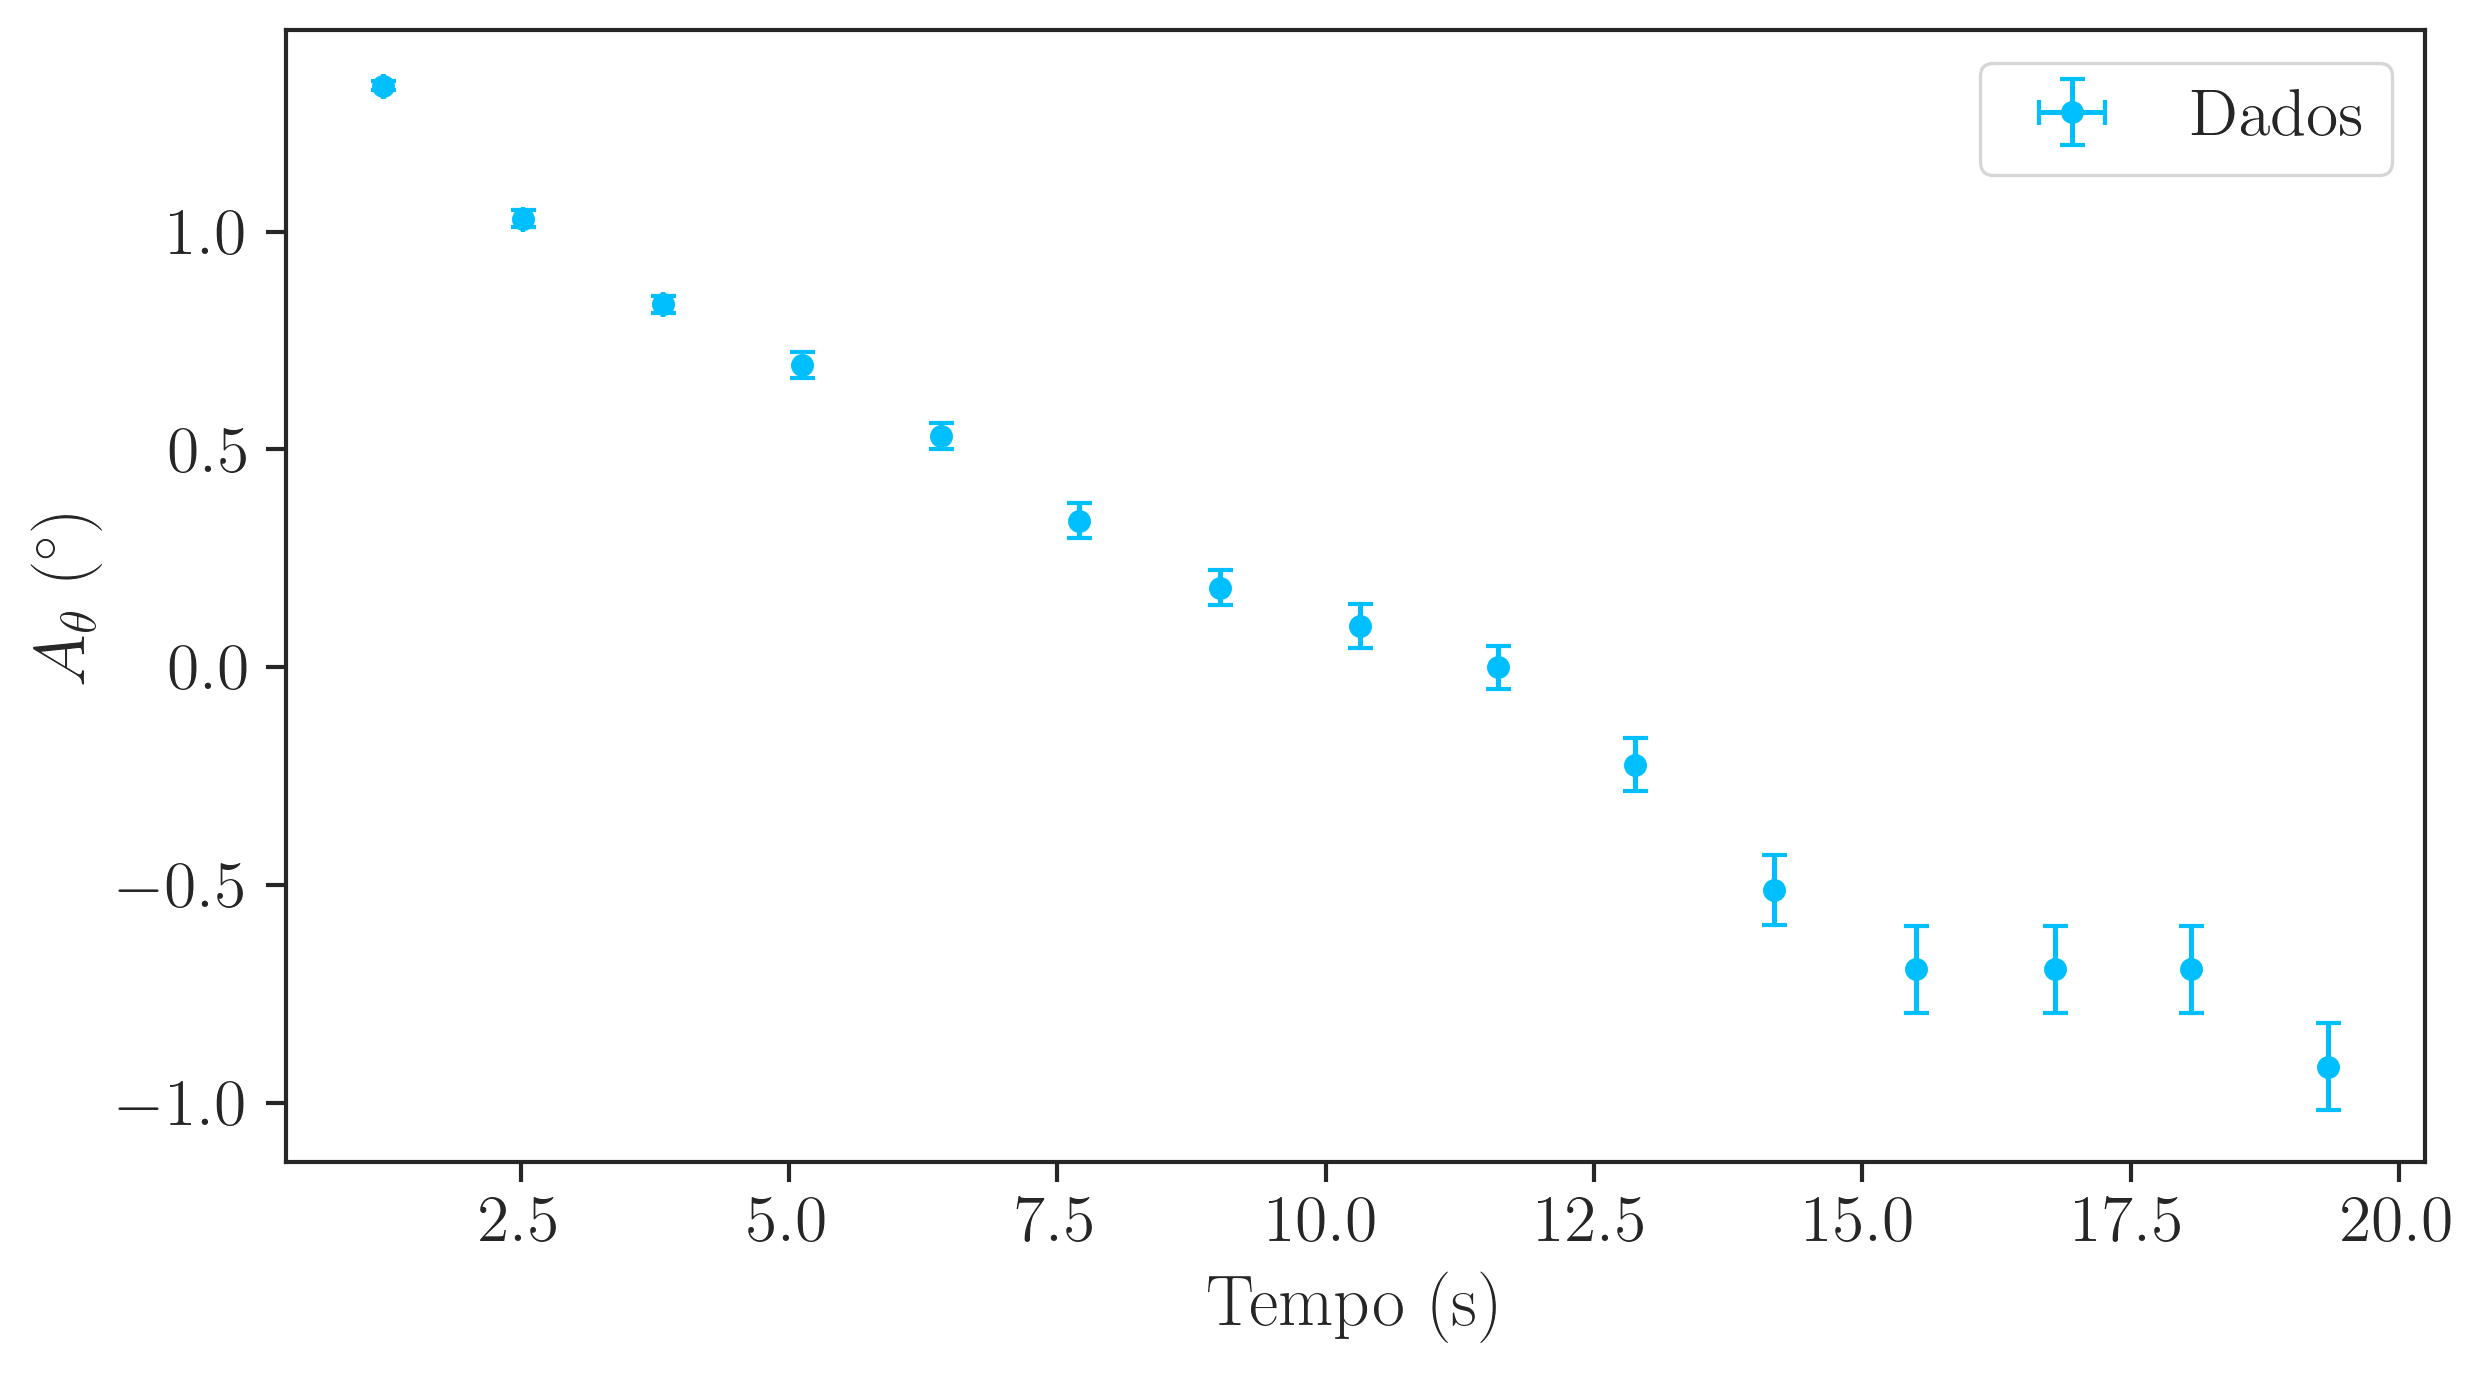

In [8]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
plt.errorbar(tempo[peaks], ln_amp,sigma_ln_amp ,5e-5, 'o',ms = 4.5, capsize=3, color = 'deepskyblue', label = r'Dados')
#Visualização dos picos
#plt.scatter(tempo_5_345[peaks], angulo_5_345[peaks], color = 'red')


plt.ylabel(r'$A_\theta \ ({}^\circ)$')
plt.xlabel('Tempo (s)')

plt.legend()
plt.show()

# Ajuste linear

In [10]:
fitpars, cov_pars = np.polyfit(tempo[peaks],ln_amp,1,w=np.power(sigma_ln_amp,-1),cov='True')
#print(fitpars, cov_pars)

coef_angular = fitpars[0]
coef_linear = fitpars[1]
sigma_angular = np.sqrt(cov_pars[0][0])
sigma_linear = np.sqrt(cov_pars[1][1])

sigma_angular = float('{:g}'.format(float('{:.1g}'.format(sigma_angular))))
sigma_linear = float('{:g}'.format(float('{:.1g}'.format(sigma_linear))))

                     
print('Coeficiente angular: %.4f +- %.3f Hz' % (coef_angular ,sigma_angular))
print('Coeficiente linear: %.2f +- %.2f' %(coef_linear,sigma_linear))

Coeficiente angular: -0.1357 +- 0.006 Hz
Coeficiente linear: 1.45 +- 0.03


In [12]:
#Calulando chi^2_red
yhat = np.polyval(fitpars, tempo[peaks])
chi_squared = np.sum(((yhat - ln_amp)/sigma_ln_amp) ** 2)
chi2_red = chi_squared/(len(ln_amp)-2)

#Imprimindo o resultado
print("chi^2_red = %.3f" % chi2_red)

chi^2_red = 7.934


## Gráfico do ajuste linear

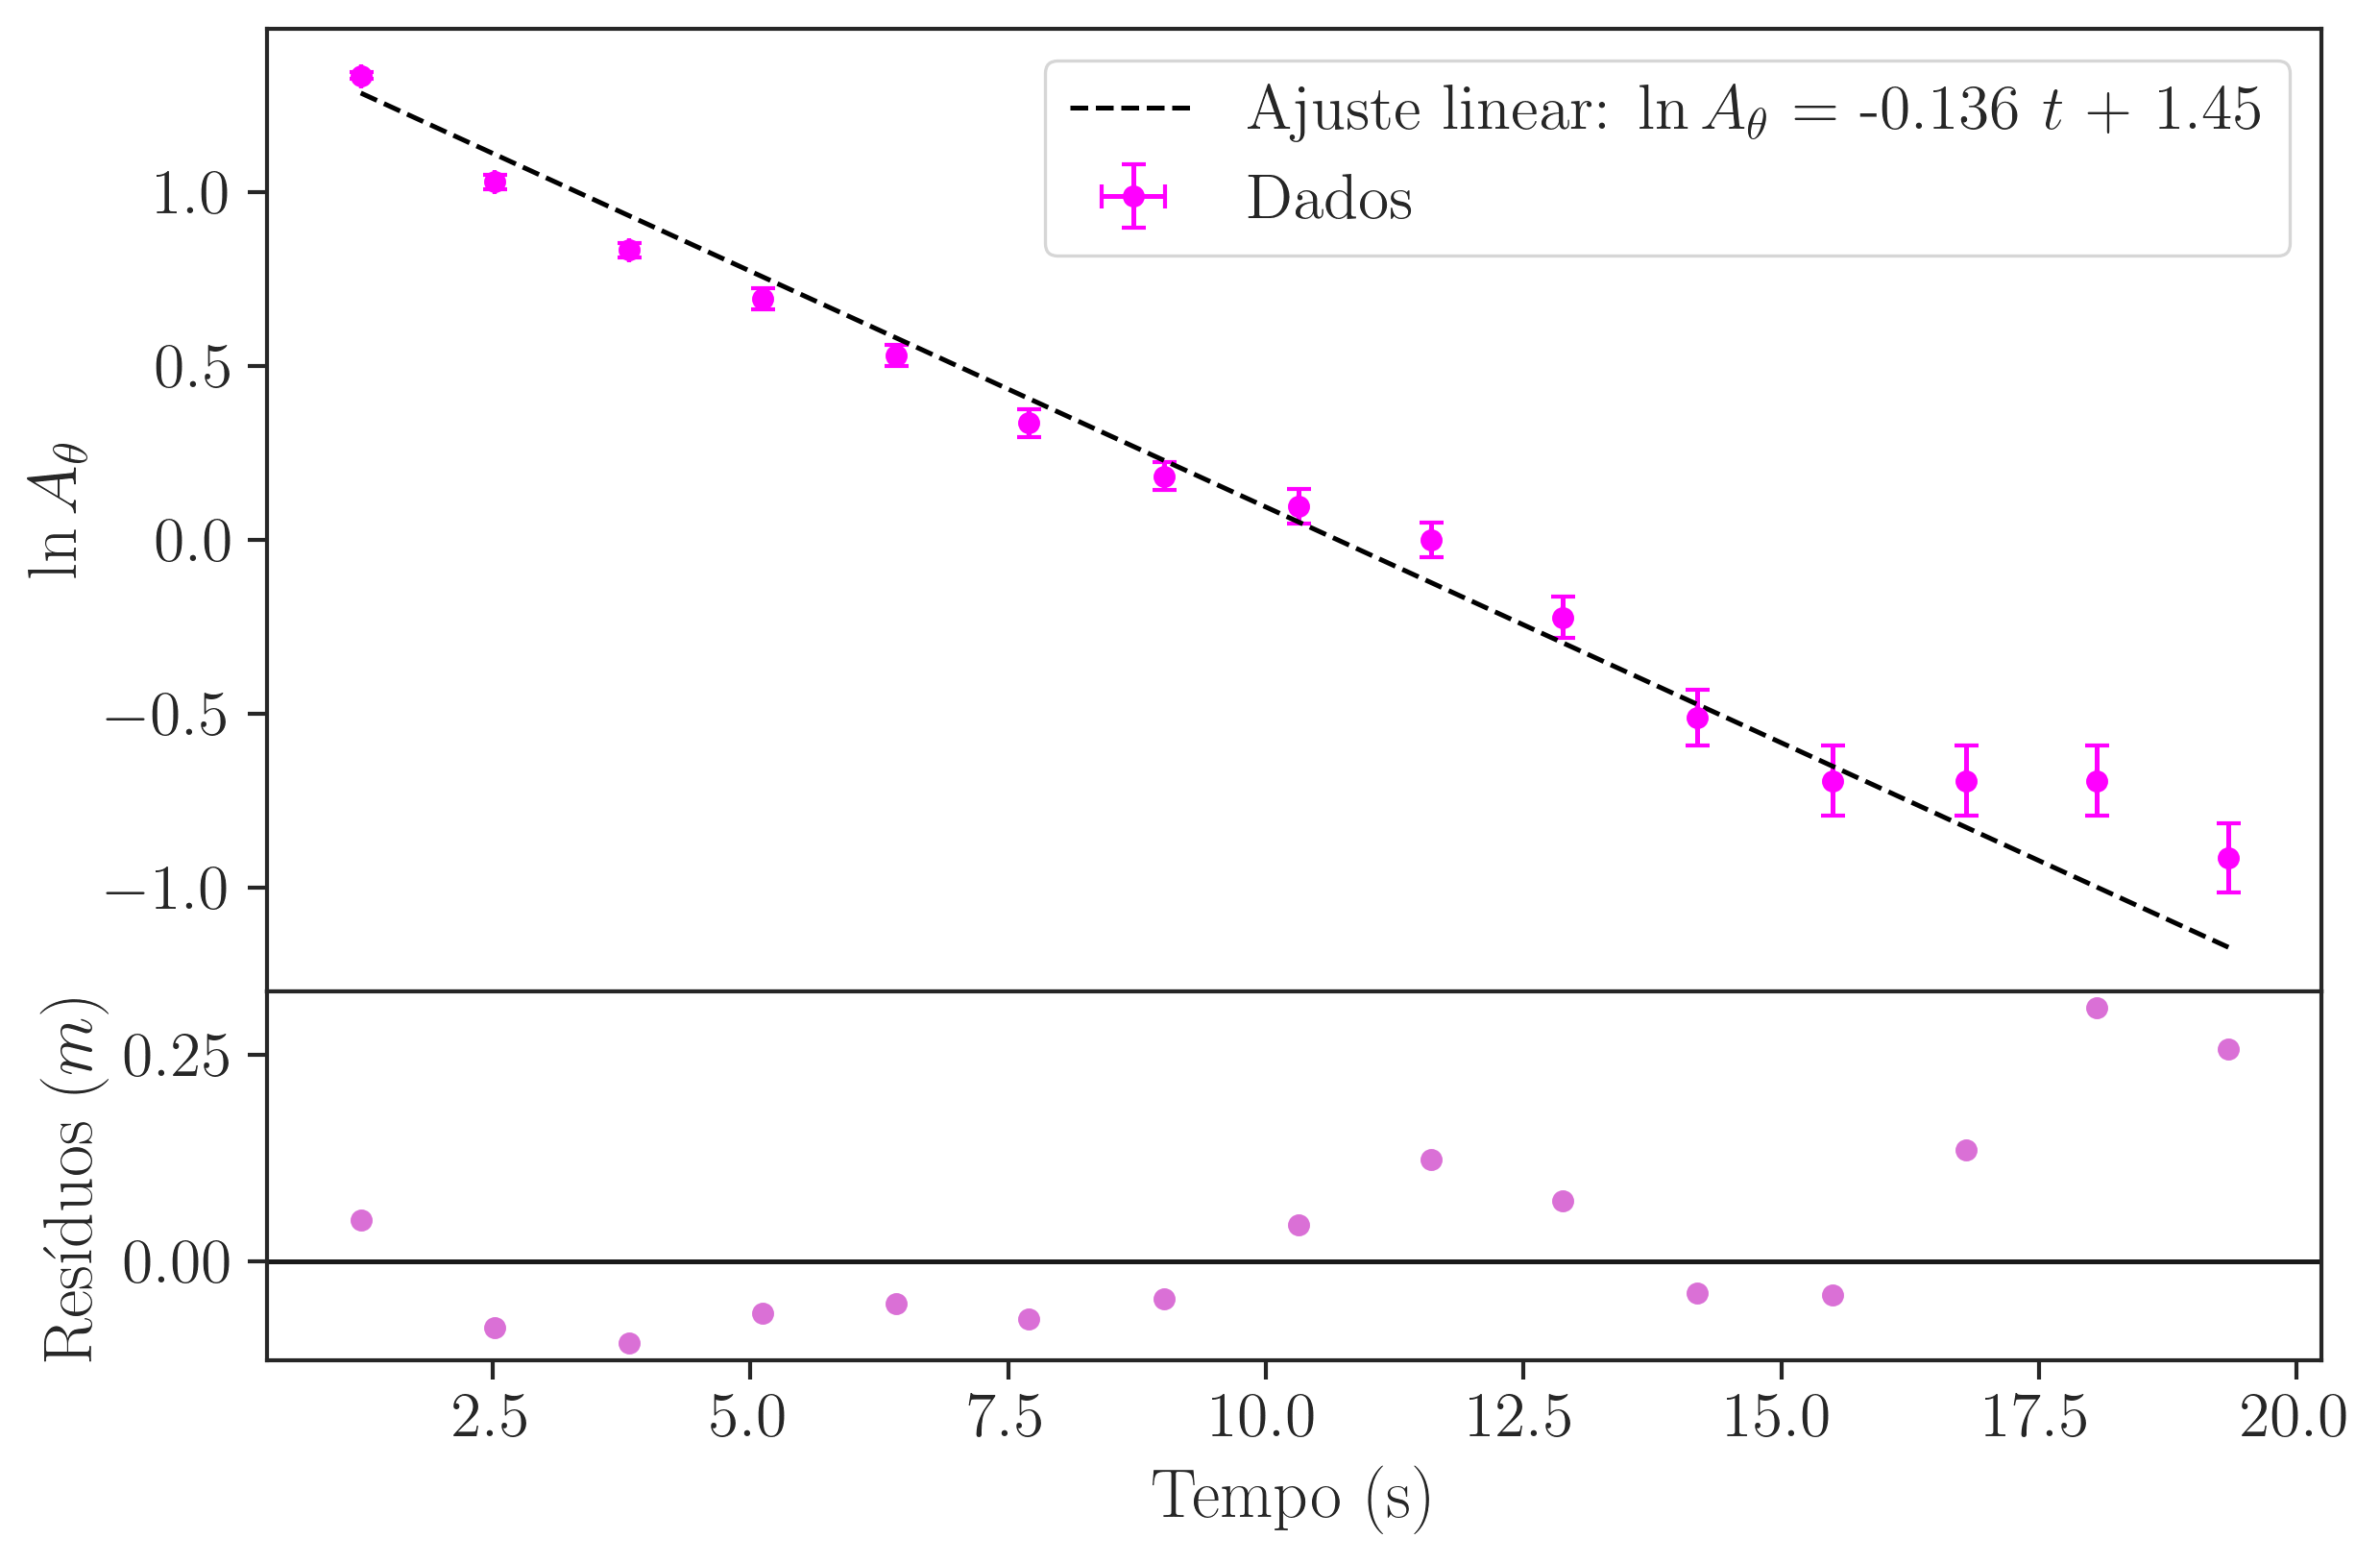

In [18]:
fig = plt.figure(figsize = [9.2,6], dpi = 300) 
gs = fig.add_gridspec(2,1, hspace=0, height_ratios=[6, 2.3])
axs = gs.subplots(sharex=True)


#Gráfico principal
axs[0] = plt.subplot(gs[0])
axs[0].errorbar(tempo[peaks],ln_amp, sigma_ln_amp,5e-5, 'o', ms = 4.5, capsize=3, color = 'magenta', label = 'Dados')
axs[0].plot(tempo[peaks],(tempo[peaks]*coef_angular + coef_linear), color ='black', ls = '--',
         label = r'Ajuste linear: $\ln{A_\theta}$ = %.3f $t$ + %.2f' % (coef_angular,abs(coef_linear)))
axs[0].set_ylabel(r'$\ln{A_{\theta}}$')
axs[0].legend()
axs[0].set_title('')

#Gráfico de resíduos
axs[1] = plt.subplot(gs[1])
resid = (ln_amp - yhat)
axs[1].plot(tempo[peaks], resid, 'o',ms = 4.5,  color = 'orchid', label = 'Residuos')
axs[1].axhline(y=0, color='k', linestyle='-')
axs[1].set_ylabel(r"Resíduos ($m$)")

#axs[0].plot(a,(a*0.2768), color ='black', ls = '--',
         #label = r'Ajuste linear: $F_r$ = %.3f $a$ - %.2f' % (coef_angular,abs(coef_linear)))

plt.xlabel('Tempo (s)')


#plt.savefig('Graphs/RodaMaxwell/AjusteLin.pdf')
plt.show()